In [447]:
!pip install --upgrade pip
!pip install Cython
!pip install cmdstanpy==0.9.5
!pip install pystan==2.19.1.1


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [448]:
pip install fbprophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [449]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from fbprophet import Prophet
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

In [450]:
# Reading in the data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [451]:
train.head()

,date,sleep_hours
0,2015-02-19,6.400000
1,2015-02-20,7.583333
2,2015-02-21,6.350000
3,2015-02-22,6.500000
4,2015-02-23,8.916667


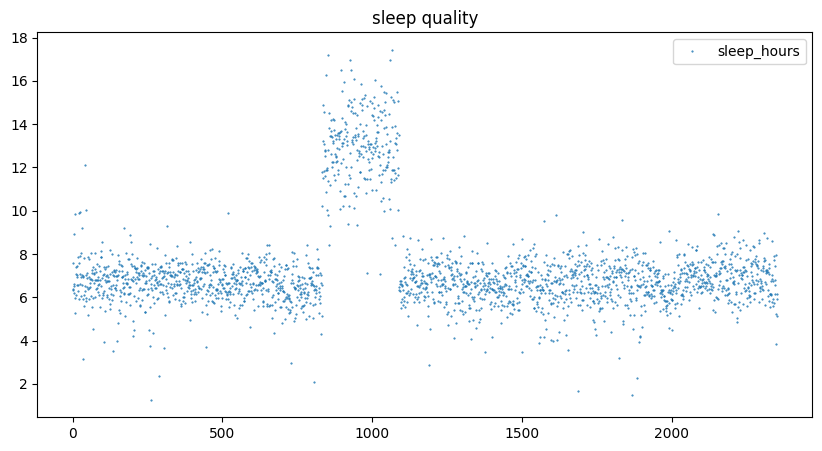

In [452]:
color_pal = sns.color_palette()
train.plot(style='.',
          figsize=(10, 5),
          ms=1,
          color=color_pal[0],
          title='sleep quality')
plt.show()

In [453]:
# Cleaning the data
train['date'] = pd.to_datetime(train['date'])
train['day_of_week'] = train['date'].dt.dayofweek # 0 = Monday, 6 = Sunday
train['hour'] = train['date'].dt.hour
train['day'] = train['date'].dt.day
train['month'] = train['date'].dt.month
train['year'] = train['date'].dt.year

In [454]:
train.head()

,date,sleep_hours,day_of_week,hour,day,month,year
0,2015-02-19,6.400000,3,0,19,2,2015
1,2015-02-20,7.583333,4,0,20,2,2015
2,2015-02-21,6.350000,5,0,21,2,2015
3,2015-02-22,6.500000,6,0,22,2,2015
4,2015-02-23,8.916667,0,0,23,2,2015


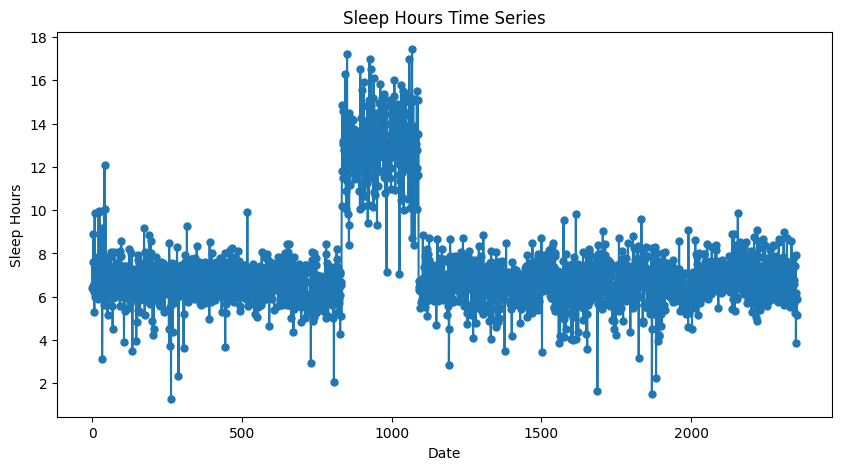

In [455]:
color_pal = sns.color_palette()

# Plot time series of sleep_hours
train['sleep_hours'].plot(
    style='-o',
    figsize=(10, 5),
    markersize=5,
    color=color_pal[0],
    title='Sleep Hours Time Series',
    xlabel='Date',
    ylabel='Sleep Hours'
)

plt.show()

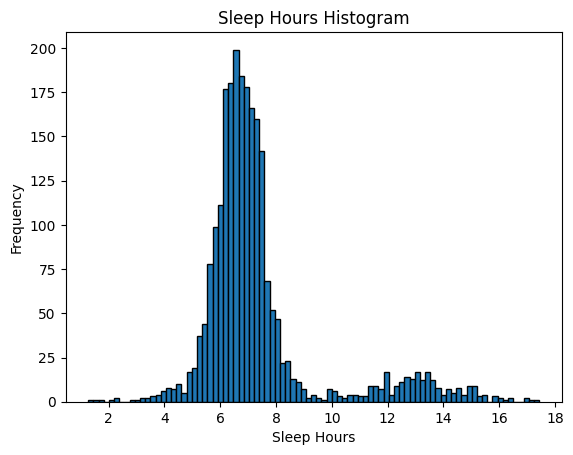

In [456]:
color_pal = sns.color_palette()

# Plot histogram of sleep_hours
plt.hist(train['sleep_hours'], bins='auto', color=color_pal[0], edgecolor='k')
plt.title('Sleep Hours Histogram')
plt.xlabel('Sleep Hours')
plt.ylabel('Frequency')

plt.show()

In [457]:
# Calculate the IQR
Q1 = train['sleep_hours'].quantile(0.25)
Q3 = train['sleep_hours'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify the outliers
outliers = train[(train['sleep_hours'] < lower_bound) | (train['sleep_hours'] > upper_bound)]

print("Number of outliers:", len(outliers))
print("Outliers:")
print(outliers)

Number of outliers: 297
Outliers:
           date  sleep_hours  day_of_week  hour  day  month  year
8    2015-02-27     9.866667            4     0   27      2  2015
21   2015-03-17     9.916667            1     0   17      3  2015
24   2015-03-26     9.950000            3     0   26      3  2015
33   2015-05-05     3.133333            1     0    5      5  2015
41   2015-05-23    12.100000            5     0   23      5  2015
...         ...          ...          ...   ...  ...    ...   ...
1890 2020-09-10     3.950000            3     0   10      9  2020
1893 2020-09-13     4.183333            6     0   13      9  2020
1894 2020-09-14     4.233333            0     0   14      9  2020
2156 2021-06-10     9.850000            3     0   10      6  2021
2350 2021-12-26     3.850000            6     0   26     12  2021

[297 rows x 7 columns]


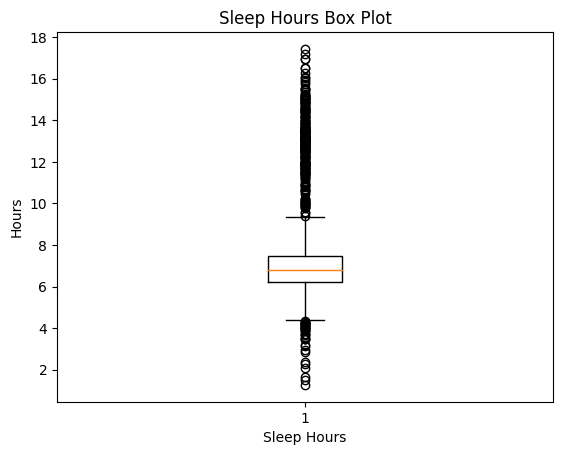

In [458]:
# Plot box plot of sleep_hours
plt.boxplot(train['sleep_hours'])
plt.title('Sleep Hours Box Plot')
plt.xlabel('Sleep Hours')
plt.ylabel('Hours')

plt.show()

In [459]:
# Calculate the IQR
Q1 = train['sleep_hours'].quantile(0.25)
Q3 = train['sleep_hours'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Calculate the median of the non-outlier values
median_no_outliers = train[(train['sleep_hours'] >= lower_bound) & (train['sleep_hours'] <= upper_bound)]['sleep_hours'].median()

# Impute outliers with the median of non-outlier values
train['sleep_hours_imputed'] = train['sleep_hours'].apply(lambda x: median_no_outliers if (x < lower_bound or x > upper_bound) else x)

# Check the first few rows of the DataFrame
print(train.head())

        date  sleep_hours  day_of_week  hour  day  month  year  \
0 2015-02-19     6.400000            3     0   19      2  2015   
1 2015-02-20     7.583333            4     0   20      2  2015   
2 2015-02-21     6.350000            5     0   21      2  2015   
3 2015-02-22     6.500000            6     0   22      2  2015   
4 2015-02-23     8.916667            0     0   23      2  2015   

   sleep_hours_imputed  
0             6.400000  
1             7.583333  
2             6.350000  
3             6.500000  
4             8.916667  


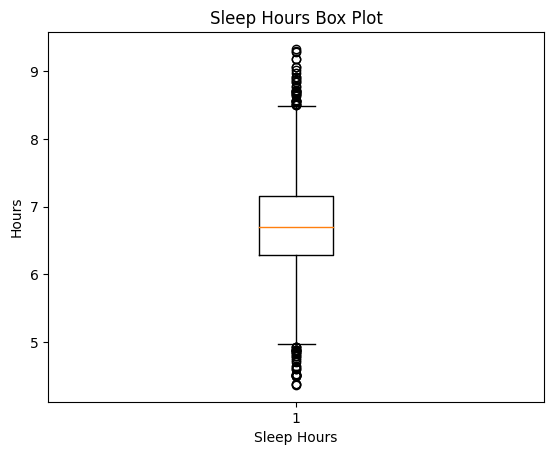

In [460]:
# Plot box plot of sleep_hours
plt.boxplot(train['sleep_hours_imputed'])
plt.title('Sleep Hours Box Plot')
plt.xlabel('Sleep Hours')
plt.ylabel('Hours')

plt.show()

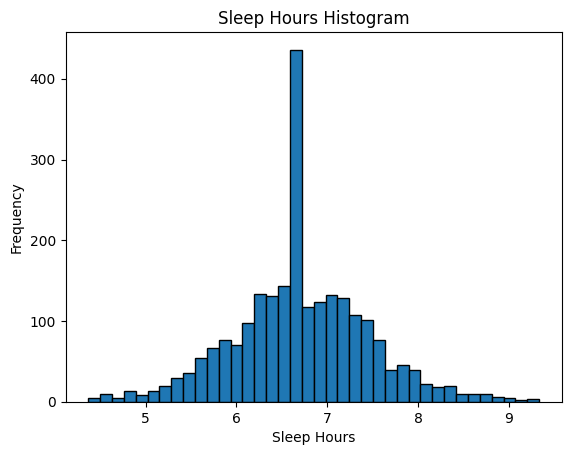

In [461]:
color_pal = sns.color_palette()

# Plot histogram of sleep_hours
plt.hist(train['sleep_hours_imputed'], bins='auto', color=color_pal[0], edgecolor='k')
plt.title('Sleep Hours Histogram')
plt.xlabel('Sleep Hours')
plt.ylabel('Frequency')

plt.show()

In [462]:
train.head()

,date,sleep_hours,day_of_week,hour,day,month,year,sleep_hours_imputed
0,2015-02-19,6.400000,3,0,19,2,2015,6.400000
1,2015-02-20,7.583333,4,0,20,2,2015,7.583333
2,2015-02-21,6.350000,5,0,21,2,2015,6.350000
3,2015-02-22,6.500000,6,0,22,2,2015,6.500000
4,2015-02-23,8.916667,0,0,23,2,2015,8.916667


In [463]:
test.shape

(419, 2)

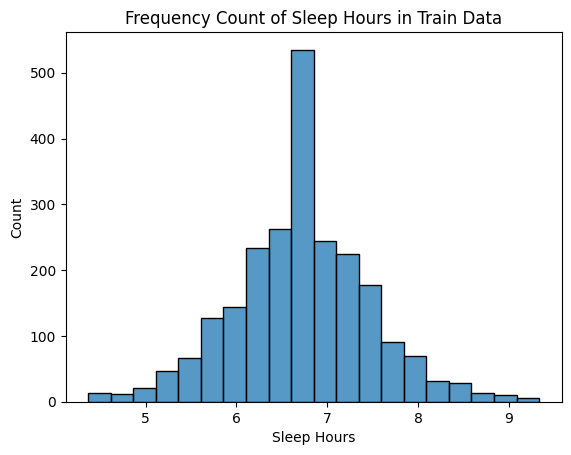

In [464]:

# Plot the frequency count of sleep hours
sns.histplot(data=train, x='sleep_hours_imputed', bins=20)
plt.title('Frequency Count of Sleep Hours in Train Data')
plt.xlabel('Sleep Hours')
plt.ylabel('Count')
plt.show()

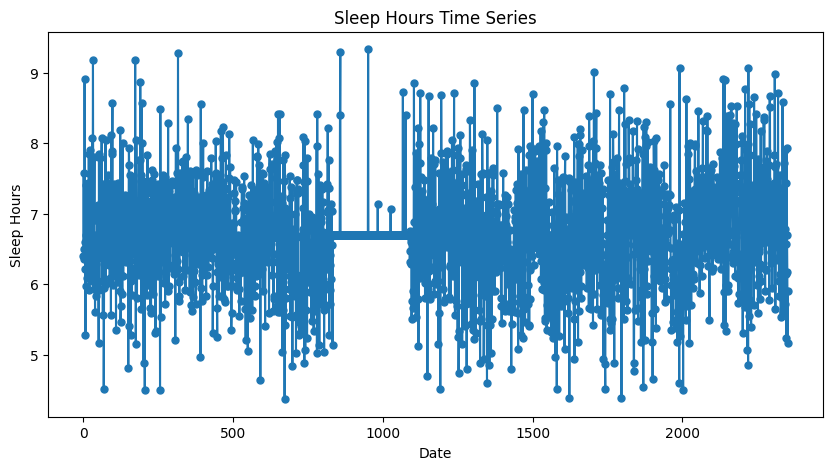

In [465]:
color_pal = sns.color_palette()

# Plot time series of sleep_hours
train['sleep_hours_imputed'].plot(
    style='-o',
    figsize=(10, 5),
    markersize=5,
    color=color_pal[0],
    title='Sleep Hours Time Series',
    xlabel='Date',
    ylabel='Sleep Hours'
)

plt.show()

In [466]:
train.head()

,date,sleep_hours,day_of_week,hour,day,month,year,sleep_hours_imputed
0,2015-02-19,6.400000,3,0,19,2,2015,6.400000
1,2015-02-20,7.583333,4,0,20,2,2015,7.583333
2,2015-02-21,6.350000,5,0,21,2,2015,6.350000
3,2015-02-22,6.500000,6,0,22,2,2015,6.500000
4,2015-02-23,8.916667,0,0,23,2,2015,8.916667


In [467]:
train.head()

,date,sleep_hours,day_of_week,hour,day,month,year,sleep_hours_imputed
0,2015-02-19,6.400000,3,0,19,2,2015,6.400000
1,2015-02-20,7.583333,4,0,20,2,2015,7.583333
2,2015-02-21,6.350000,5,0,21,2,2015,6.350000
3,2015-02-22,6.500000,6,0,22,2,2015,6.500000
4,2015-02-23,8.916667,0,0,23,2,2015,8.916667


In [468]:
train.head()

,date,sleep_hours,day_of_week,hour,day,month,year,sleep_hours_imputed
0,2015-02-19,6.400000,3,0,19,2,2015,6.400000
1,2015-02-20,7.583333,4,0,20,2,2015,7.583333
2,2015-02-21,6.350000,5,0,21,2,2015,6.350000
3,2015-02-22,6.500000,6,0,22,2,2015,6.500000
4,2015-02-23,8.916667,0,0,23,2,2015,8.916667


In [469]:
train.shape

(2354, 8)

In [470]:
# create 'ds' column from 'Year', 'Month', and 'Day' columns
train['ds'] = pd.DatetimeIndex(train['year'].astype(str) + '-' + train['month'].astype(str) + '-' + train['day'].astype(str))

print(train)

           date  sleep_hours  day_of_week  hour  day  month  year  \
0    2015-02-19     6.400000            3     0   19      2  2015   
1    2015-02-20     7.583333            4     0   20      2  2015   
2    2015-02-21     6.350000            5     0   21      2  2015   
3    2015-02-22     6.500000            6     0   22      2  2015   
4    2015-02-23     8.916667            0     0   23      2  2015   
...         ...          ...          ...   ...  ...    ...   ...   
2349 2021-12-25     7.933333            5     0   25     12  2021   
2350 2021-12-26     3.850000            6     0   26     12  2021   
2351 2021-12-29     6.175000            2     0   29     12  2021   
2352 2021-12-30     5.158333            3     0   30     12  2021   
2353 2021-12-31     5.908333            4     0   31     12  2021   

      sleep_hours_imputed         ds  
0                6.400000 2015-02-19  
1                7.583333 2015-02-20  
2                6.350000 2015-02-21  
3              

In [471]:
# create 'y' column from 'sleep_hours_imputed' column
train['y'] = train['sleep_hours_imputed']

In [472]:
# drop unnecessary columns and rename columns
train.drop(['date', 'year', 'month', 'day', 'hour', 'sleep_hours_imputed', 'day_of_week', 'sleep_hours'], axis=1, inplace=True)
train.columns = ['ds', 'y']

print(train.head())

          ds         y
0 2015-02-19  6.400000
1 2015-02-20  7.583333
2 2015-02-21  6.350000
3 2015-02-22  6.500000
4 2015-02-23  8.916667


In [473]:
m = Prophet(interval_width=0.95, daily_seasonality=True)
model = m.fit(train)

/usr/local/lib/python3.9/dist-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [474]:
future = m.make_future_dataframe(periods=100,freq='D')
forecast = m.predict(future)
forecast.head()

/usr/local/lib/python3.9/dist-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/usr/local/lib/python3.9/dist-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-02-19,6.479288,5.359076,8.275385,6.479288,6.479288,0.361176,0.361176,0.361176,0.319559,...,0.023022,0.023022,0.023022,0.018595,0.018595,0.018595,0.0,0.0,0.0,6.840464
1,2015-02-20,6.479134,5.342025,8.217183,6.479134,6.479134,0.360317,0.360317,0.360317,0.319559,...,0.021200,0.021200,0.021200,0.019558,0.019558,0.019558,0.0,0.0,0.0,6.839451
2,2015-02-21,6.478979,5.588456,8.463221,6.478979,6.478979,0.570498,0.570498,0.570498,0.319559,...,0.229717,0.229717,0.229717,0.021223,0.021223,0.021223,0.0,0.0,0.0,7.049478
3,2015-02-22,6.478825,5.532618,8.431885,6.478825,6.478825,0.500444,0.500444,0.500444,0.319559,...,0.157303,0.157303,0.157303,0.023583,0.023583,0.023583,0.0,0.0,0.0,6.979270
4,2015-02-23,6.478671,5.238447,8.125936,6.478671,6.478671,0.197386,0.197386,0.197386,0.319559,...,-0.148793,-0.148793,-0.148793,0.026620,0.026620,0.026620,0.0,0.0,0.0,6.676057


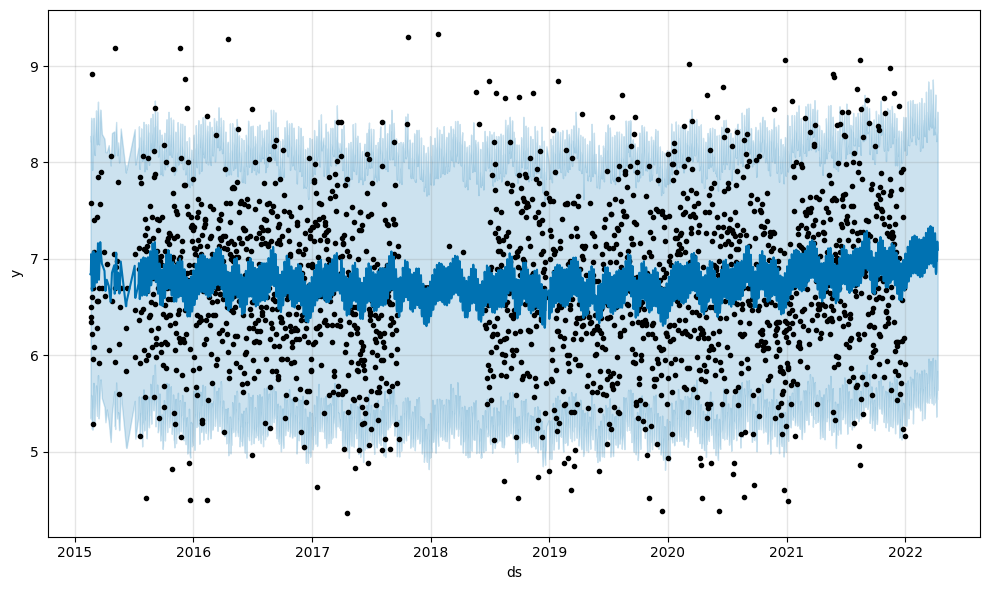

In [475]:
plot1 = m.plot(forecast)

/usr/local/lib/python3.9/dist-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/usr/local/lib/python3.9/dist-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/usr/local/lib/python3.9/dist-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



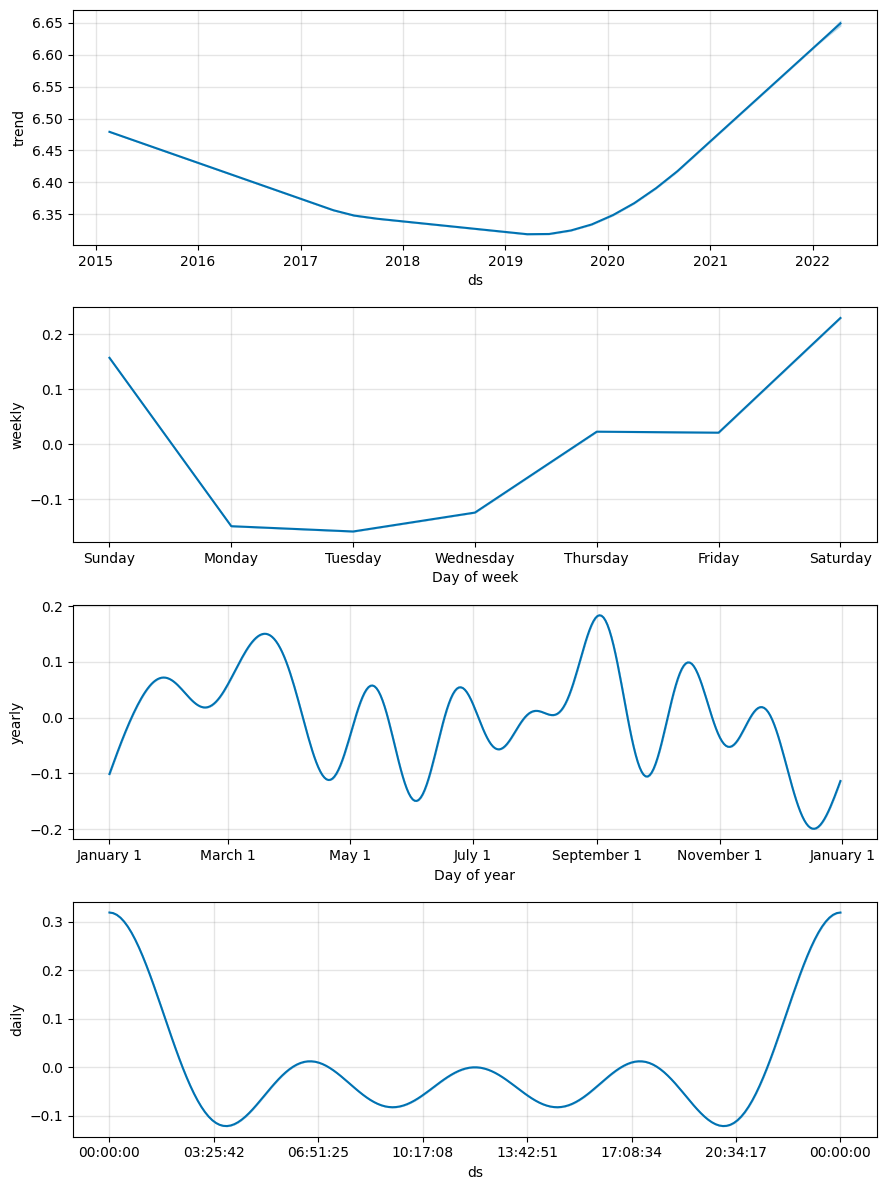

In [476]:
plt2 = m.plot_components(forecast)

/usr/local/lib/python3.9/dist-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/usr/local/lib/python3.9/dist-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



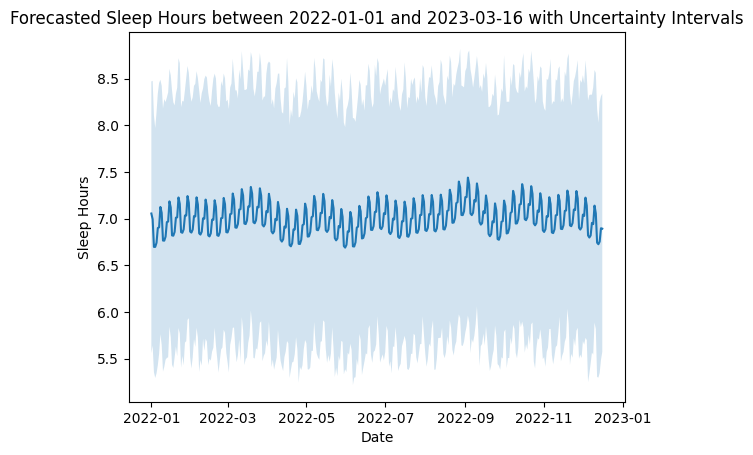

In [477]:
# create future dates for prediction
future_dates = m.make_future_dataframe(periods=350)  # 350 days from last date in training data

# make predictions for future dates
forecast = m.predict(future_dates)

# filter forecasted sleep hours between 2022-01-01 and 2023-03-16
forecast_filtered = forecast[(forecast['ds'] >= '2022-01-01') & (forecast['ds'] <= '2023-03-16')][['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# plot forecasted sleep hours between 2022-01-01 and 2023-03-16 with uncertainty intervals
plt.plot(forecast_filtered['ds'], forecast_filtered['yhat'])
plt.fill_between(forecast_filtered['ds'], forecast_filtered['yhat_lower'], forecast_filtered['yhat_upper'], alpha=0.2)
plt.xlabel('Date')
plt.ylabel('Sleep Hours')
plt.title('Forecasted Sleep Hours between 2022-01-01 and 2023-03-16 with Uncertainty Intervals')
plt.show()

In [478]:
import pandas as pd
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
# create future dates for prediction
future_dates = m.make_future_dataframe(periods=365)  # 365 days from last date in training data

# perform cross-validation and obtain a DataFrame of predicted values and actual values
cv_results = cross_validation(m, initial='730 days', horizon='365 days')

# calculate RMSE
rmse = performance_metrics(cv_results)['rmse'].mean()

print('RMSE:', rmse)

INFO:fbprophet:Making 8 forecasts with cutoffs between 2017-07-02 12:00:00 and 2020-12-31 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/usr/local/lib/python3.9/dist-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/usr/local/lib/python3.9/dist-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/usr/local/lib/python3.9/dist-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/usr/local/lib/python3.9/dist-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.co

RMSE: 0.7677850486927773


In [479]:
test.head()

,date,sleep_hours
0,2022-01-01,1
1,2022-01-02,1
2,2022-01-03,1
3,2022-01-04,1
4,2022-01-05,1


In [483]:
import pandas as pd
from fbprophet import Prophet

# Load test dataset
test_df = pd.read_csv("test.csv")

# Rename columns
test_df = test_df.rename(columns={"date": "ds", "sleep_hours": "y"})

# Convert 'ds' column in test_df to datetime format
test_df['ds'] = pd.to_datetime(test_df['ds'])

# Merge test dataset with the forecast
merged_df = pd.merge(test_df, forecast_filtered, on='ds', how='left')

# Extract only the required columns
submission = merged_df[['ds', 'yhat']]
submission = submission.rename(columns={"ds": "date", "yhat": "sleep_hours"})

# Fill NaN values with a reasonable default (e.g., average sleep hours)
submission['sleep_hours'].fillna(submission['sleep_hours'].mean(), inplace=True)

# Save the result to a new csv file
submission.to_csv("submission.csv", index=False)

# Display the result
print(submission)


          date  sleep_hours
0   2022-01-01     7.055664
1   2022-01-02     6.993598
2   2022-01-03     6.697820
3   2022-01-04     6.698432
4   2022-01-05     6.742933
..         ...          ...
414 2023-03-12     7.010395
415 2023-03-13     7.010395
416 2023-03-14     7.010395
417 2023-03-15     7.010395
418 2023-03-16     7.010395

[419 rows x 2 columns]


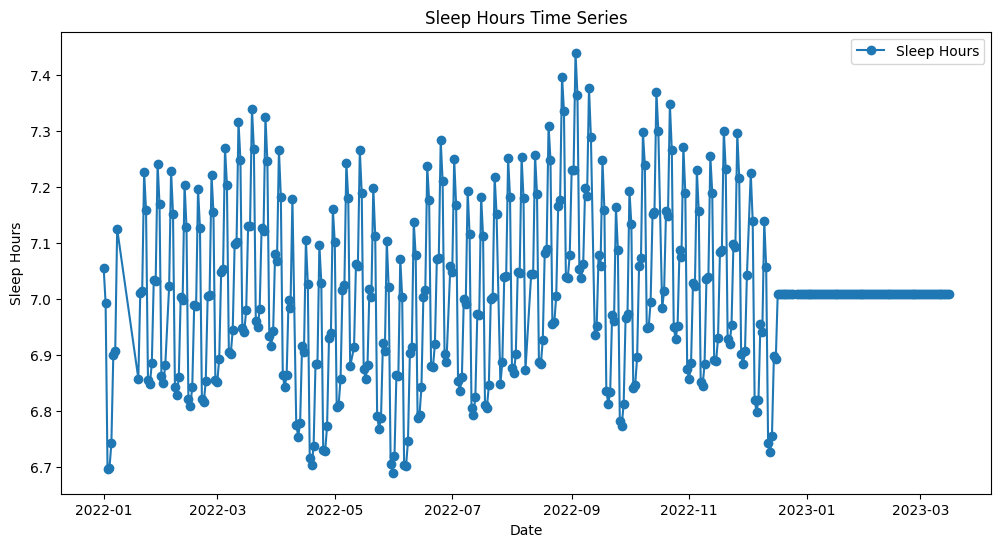

In [484]:
import matplotlib.pyplot as plt

# Convert 'date' column to datetime
submission['date'] = pd.to_datetime(submission['date'])

# Set the plot size
plt.figure(figsize=(12, 6))

# Plot the sleep hours from the submission output
plt.plot(submission['date'], submission['sleep_hours'], label="Sleep Hours", marker='o')

# Add labels, title, and legend
plt.xlabel("Date")
plt.ylabel("Sleep Hours")
plt.title("Sleep Hours Time Series")
plt.legend()

# Display the plot
plt.show()
